In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import random
import numpy as np

# 모델 재현을 위한 랜덤시드 고정
def set_random_seed(seed_value=42):
    # Python의 기본 난수 시드 설정
    random.seed(seed_value)
    # NumPy 난수 시드 설정
    np.random.seed(seed_value)
    # PyTorch 난수 시드 설정 (CPU)
    torch.manual_seed(seed_value)
    # PyTorch 난수 시드 설정 (GPU)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    # CuDNN 설정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

In [ ]:
def data_loading(data_dir, batch_size, train_transform, val_transform):
    # 데이터셋 경로
    train_path = os.path.join(data_dir, 'training_image')
    val_path = os.path.join(data_dir, 'validation_image')

    # 데이터셋 로드
    train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_path, transform=val_transform)

    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)

    return train_loader, val_loader

In [ ]:
# GPU 사용
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
################################################################################
# Training
################################################################################
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange


def training(experiment_name, save_dir, data_loader, optimizer, criterion, scheduler=None):
    """
    experiment_name: 실험 이름
    save_dir: 모델 저장 경로
    data_loader: 데이터로더
    optimizer: 옵티마이저
    criterion: 손실 함수
    batch_size: 배치 사이즈
    scheduler: 스케줄러
    """

    train_loader, val_loader = data_loader

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(f"{save_dir}/{experiment_name}", exist_ok=True)

    min_loss = np.inf

    train_loss_chart = []
    val_loss_chart = []

    train_acc_chart = []
    val_acc_chart = []

    for epoch in trange(NUM_EPOCHS):
        model.train()

        train_loss = 0
        train_correct = 0
        total = 0
        for images, labels in tqdm(train_loader, leave=False):
            images, labels = images.to(device), labels.to(device)
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True) # [4] 비동기 메모리 전송

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / total

        train_loss_chart.append(train_loss)
        train_acc_chart.append(train_acc)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")


        model.eval()
        val_loss = 0
        val_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, leave=False):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader)
            val_acc = 100 * val_correct / total

        val_loss_chart.append(val_loss)
        val_acc_chart.append(val_acc)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # 가중치 스케줄러 업데이트
        if scheduler is not None:
            scheduler.step()

        # val_loss가 감소하면 모델 저장(최고 성능 모델 저장)
        if val_loss < min_loss:
            print(f"[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!")
            min_loss = val_loss
            torch.save(model.state_dict(), f'{save_dir}/{experiment_name}/best_model.pth')

        # 모델 중간 저장
        if epoch+1 >= 20 and (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), f'{save_dir}/{experiment_name}/model_{epoch+1}.pth')
            print(f"Model saved at epoch -> {epoch+1}")


    # 학습 loss, acc 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_chart, label='Train Loss')
    plt.plot(val_loss_chart, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_chart, label='Train Accuracy')
    plt.plot(val_acc_chart, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()

    # 학습 시각화 저장
    plt.savefig(f'{save_dir}/{experiment_name}/train_val_loss.png')
    plt.show()

    # 모델 최종 저장
    torch.save(model.state_dict(), f'{save_dir}/{experiment_name}/model_final({epoch+1}).pth')
    print(f"Model saved at epoch {epoch+1}")

In [ ]:
# 파라미터 설정
LR = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 80
WEIGHT_DECAY = 5e-4

# 실험 이름, 저장 경로 설정
EXP_NAME = 'exp1',
SAVE_DIR = './baseline_0',

# 데이터 전처리
t_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # ImageNet 정규화
])
v_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # ImageNet 정규화
])

data_loader = data_loading(
    data_dir='../categorized_data',
    batch_size=BATCH_SIZE,
    train_transform=t_transform,
    val_transform=v_transform
)


# ResNet18 모델 불러오기(가중치 X)
model = models.resnet18(weights=None, num_classes=31)
# 가중치 초기화
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
model.apply(init_weights)
model = model.to(device)


# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)


training(
    experiment_name=EXP_NAME,
    save_dir=SAVE_DIR,
    data_loader=data_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=None
)

In [11]:
# best model 성능 확인
best_path = f"{SAVE_DIR}/{EXP_NAME}/best_model.pth"
model.load_state_dict(torch.load(best_path, weights_only=True))

def evaluate_model(model, data_loader):
    model.eval()
    val_loss = 0
    val_correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss /= len(data_loader)
        val_acc = 100 * val_correct / total
    
    print(f"Best Model Performance | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return np.array(all_preds), np.array(all_labels), val_loss, val_acc


y_pred, y_true, val_loss, val_acc = evaluate_model(model, data_loader[1])

Best Model Performance | Val Loss: 1.8547, Val Acc: 62.88%


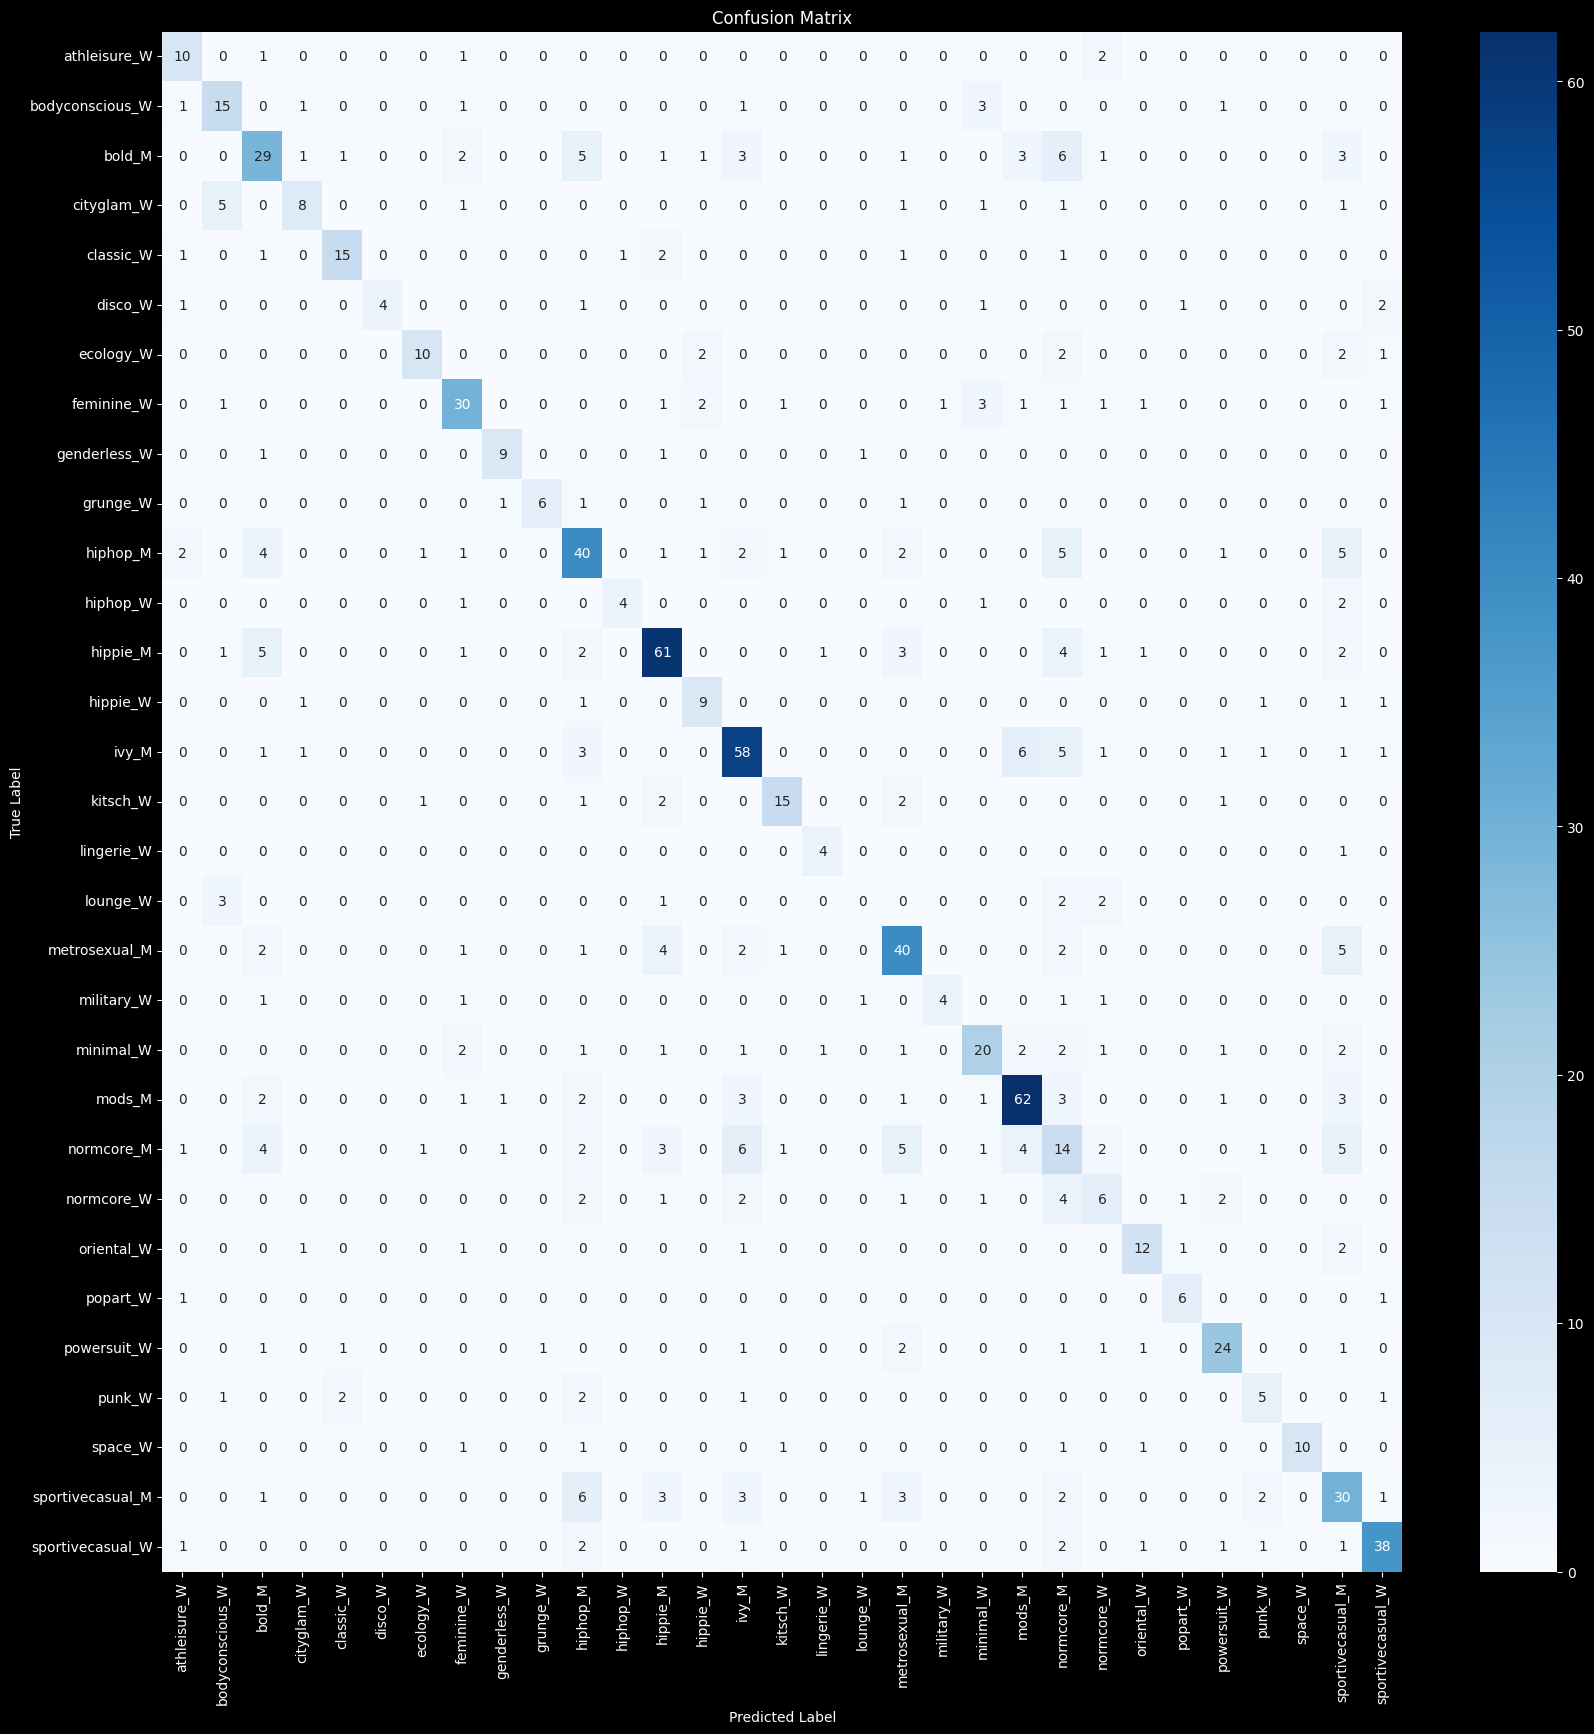

                  precision    recall  f1-score   support

    athleisure_W      0.556     0.714     0.625        14
 bodyconscious_W      0.577     0.652     0.612        23
          bold_M      0.547     0.509     0.527        57
      cityglam_W      0.615     0.444     0.516        18
       classic_W      0.789     0.682     0.732        22
         disco_W      1.000     0.400     0.571        10
       ecology_W      0.769     0.588     0.667        17
      feminine_W      0.667     0.682     0.674        44
    genderless_W      0.750     0.750     0.750        12
        grunge_W      0.857     0.600     0.706        10
        hiphop_M      0.548     0.606     0.576        66
        hiphop_W      0.800     0.500     0.615         8
        hippie_M      0.744     0.744     0.744        82
        hippie_W      0.562     0.643     0.600        14
           ivy_M      0.682     0.734     0.707        79
        kitsch_W      0.750     0.682     0.714        22
      lingeri

In [12]:
# 어떤 class를 분류 못 하는지 확인
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def print_classification_report(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes, digits=3)
    print(report)

# 클래스 이름 리스트
class_names = train_dataset.classes

# 혼동 행렬 플롯
plot_confusion_matrix(y_true, y_pred, class_names)

# 분류 보고서 출력
print_classification_report(y_true, y_pred, class_names)

In [13]:
# 가장 성능이 낮은 클래스 10개 출력
class_accuracy = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
class_accuracy = {k: v['f1-score'] for k, v in class_accuracy.items() if k in class_names}
worst_classes = sorted(class_accuracy.items(), key=lambda x: x[1])[:10]

print("Worst performing classes:")
for cls, score in worst_classes:
    print(f"{cls}: {score:.3f}")

Worst performing classes:
lounge_W: 0.000
normcore_M: 0.255
normcore_W: 0.308
punk_W: 0.435
sportivecasual_M: 0.504
cityglam_W: 0.516
bold_M: 0.527
military_W: 0.571
disco_W: 0.571
hiphop_M: 0.576
